In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

Interesting Notes
=================
1. There are very few(under 200) games with a global sales of above 5 million, with 80 of them being from Nintendo.
2. If a game is released on multiple platforms, each platform's sales are counted separately. This means we will need to combine sales from different platforms to get the total sales for a game.
3. The top 5 best-selling games are all from Nintendo, with "Wii Sports" leading the pack with over 82 million copies sold. This is likely because each game is only released on one platform, making it easier to track total sales.

In [12]:
sales = pd.read_csv('game_data.csv')
sales['Year'] = sales['Year'].astype('Int64')
sales.drop(columns=['Unnamed: 0'], inplace=True)

In [13]:
sales.head()

,all_time_peak,last_30_day_avg,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,4725,370.36,99.0,Call of Duty: World at War,X360,2008,Shooter,Activision,4.79,1.90,0.0,0.69,7.37
1,4725,370.36,167.0,Call of Duty: World at War,PS3,2008,Shooter,Activision,2.72,1.87,0.0,0.84,5.43
2,4725,370.36,863.0,Call of Duty: World at War,Wii,2008,Shooter,Activision,1.20,0.59,0.0,0.19,1.97
3,4725,370.36,2290.0,Call of Duty: World at War,DS,2008,Shooter,Activision,0.57,0.26,0.0,0.08,0.91
4,4725,370.36,7951.0,Call of Duty: World at War,PC,2008,Shooter,Activision,0.02,0.13,0.0,0.03,0.19


In [14]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1767 entries, 0 to 1766
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   all_time_peak    1767 non-null   int64  
 1   last_30_day_avg  1767 non-null   float64
 2   Rank             1682 non-null   float64
 3   Name             1682 non-null   object 
 4   Platform         1682 non-null   object 
 5   Year             1666 non-null   Int64  
 6   Genre            1682 non-null   object 
 7   Publisher        1676 non-null   object 
 8   NA_Sales         1682 non-null   float64
 9   EU_Sales         1682 non-null   float64
 10  JP_Sales         1682 non-null   float64
 11  Other_Sales      1682 non-null   float64
 12  Global_Sales     1682 non-null   float64
dtypes: Int64(1), float64(7), int64(1), object(4)
memory usage: 181.3+ KB


In [15]:
sales.describe()

,all_time_peak,last_30_day_avg,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,1767.000000,1767.000000,1682.000000,1666.0,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000
mean,29702.720996,1376.931183,7506.143282,2009.517407,0.299911,0.218098,0.032331,0.067765,0.618240
std,97186.039133,4686.086527,4922.159959,4.836796,0.568509,0.366210,0.144675,0.122598,1.030237
min,0.000000,0.000000,99.000000,1983.0,0.000000,0.000000,0.000000,0.000000,0.010000
25%,297.000000,11.360000,3161.750000,2007.0,0.010000,0.020000,0.000000,0.010000,0.070000
50%,1414.000000,35.700000,7208.000000,2010.0,0.100000,0.080000,0.000000,0.020000,0.220000
75%,11808.000000,302.470000,11914.250000,2014.0,0.297500,0.240000,0.010000,0.060000,0.637500
max,486918.000000,37532.450000,16594.000000,2016.0,4.790000,3.150000,2.130000,1.100000,7.370000


In [16]:
sales = sales.drop_duplicates()
sales_combined = (
    sales.groupby('Name')
    .agg({
        'Platform': lambda x: list(pd.unique(x.dropna())),
        'Year': 'max',
        'Rank': 'max',
        'Genre': lambda x: list(pd.unique(x.dropna())),
        'Publisher': lambda x: list(pd.unique(x.dropna())),
        'all_time_peak': 'max',
        'last_30_day_avg': 'max',
        'NA_Sales': 'sum',
        'EU_Sales': 'sum',
        'JP_Sales': 'sum',
        'Other_Sales': 'sum',
        'Global_Sales': 'sum',
    })
    .reset_index()
)

<Axes: xlabel='Global_Sales', ylabel='Count'>

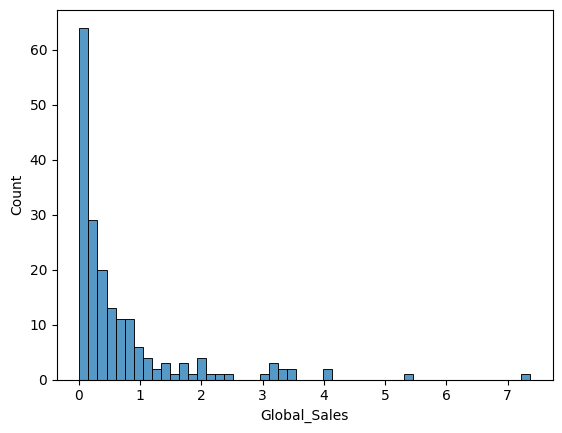

In [17]:
sns.histplot(data=sales[sales['Genre'].astype(str).str.contains('Shooter', na=False)], x='Global_Sales', bins=50)

<Axes: xlabel='Global_Sales', ylabel='Count'>

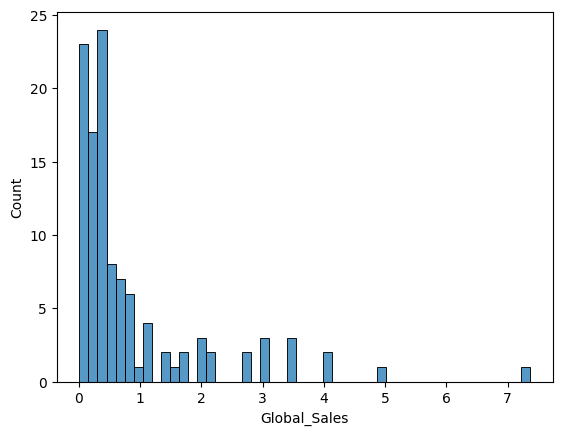

In [18]:
sns.histplot(data=sales[sales['Platform'].astype(str).str.contains('X360', na=False)], x='Global_Sales', bins=50)

In [19]:
sales_combined['Platform'] = sales_combined['Platform'].apply(lambda x: x if isinstance(x, list) else [])
sales_combined['Genre'] = sales_combined['Genre'].apply(lambda x: x if isinstance(x, list) else [])

mlb_platform = MultiLabelBinarizer()
mlb_genre = MultiLabelBinarizer()


# Apply encoding
platform_encoded = pd.DataFrame(mlb_platform.fit_transform(sales_combined['Platform']), columns=[f"Platform_{cat}" for cat in mlb_platform.classes_])
genre_encoded = pd.DataFrame(mlb_genre.fit_transform(sales_combined['Genre']), columns=[f"Genre_{cat}" for cat in mlb_genre.classes_])


# Combine encoded columns with numeric predictors
final_df = pd.concat([sales_combined[['all_time_peak', 'last_30_day_avg', 'Year', 'Rank', 'Global_Sales']], platform_encoded, genre_encoded], axis=1)
final_df = final_df.dropna(subset=['Year'])

In [20]:

x = final_df.drop(columns = ['Global_Sales'])
y = np.log1p(final_df['Global_Sales'])

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

# Split data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train[['all_time_peak', 'last_30_day_avg', 'Year', 'Rank']] = scaler.fit_transform(X_train[['all_time_peak', 'last_30_day_avg', 'Year', 'Rank']])
X_test[['all_time_peak', 'last_30_day_avg', 'Year', 'Rank']] = scaler.transform(X_test[['all_time_peak', 'last_30_day_avg', 'Year', 'Rank']])

model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [1, 3, 5],
    'min_samples_leaf': [1, 2, 3]
}

# GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Predictions and evaluation
preds = best_model.predict(X_test)
r2 = r2_score(y_test, preds)
rmse = mean_squared_error(y_test, preds)

print("Best Parameters:", grid_search.best_params_)
print("R²:", r2)
print("RMSE (log scale):", rmse)
print("Top 10 Feature Importances:")
importances = pd.Series(best_model.feature_importances_, index=x.columns).sort_values(ascending=False)
print(importances.head(10))



c:\Users\corbi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
81 fits failed out of a total of 243.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\corbi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\corbi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "c:\U

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
R²: 0.6604439737136665
RMSE (log scale): 0.12692247834650397
Top 10 Feature Importances:
Rank               0.290563
Platform_X360      0.181940
last_30_day_avg    0.143909
all_time_peak      0.057451
Platform_PS3       0.053692
Platform_SAT       0.035944
Platform_PS2       0.035577
Year               0.031940
Platform_PC        0.029742
Platform_GC        0.028669
dtype: float64
